In [2]:
import re
import pandas as pd
from collections import Counter  

def analyze_fasta_mpnn(file_path):
    '''
    Analyze a ProteinMPNN output fasta file and extract sequences, scores, and mutations.
    The fuction returns a pandas DataFrame.
    '''
    # Read the file
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Initialize lists to store extracted data
    sequences = []
    metadata = []
    current_id = None
    current_sequence = ""

    # Process the file line by line
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        if line.startswith(">"):
            # Save the previous sequence if there was one
            if current_id != None and current_sequence:
                sequences.append((current_id, current_sequence))
                current_sequence = ""
            
            # Process the header line
            # First, extract the base identifier
            if "," in line:
                current_id = line[1:line.find(",")]
            else:
                current_id = line[1:]
            
            # Extract score information
            score = None
            global_score = None
            seq_recovery = None
            temperature = None
            
            # Extract score
            score_match = re.search(r"score=([-\d\.]+)", line)
            if score_match:
                score = float(score_match.group(1))
            
            # Extract global score
            global_match = re.search(r"global_score=([-\d\.]+)", line)
            if global_match:
                global_score = float(global_match.group(1))
            
            # Extract sequence recovery
            recovery_match = re.search(r"seq_recovery=([-\d\.]+)", line)
            if recovery_match:
                seq_recovery = float(recovery_match.group(1))
            
            # Extract temperature
            temp_match = re.search(r"T=(\d+\.\d+)", line)
            if temp_match:
                temperature = float(temp_match.group(1))
                # If ID starts with "T=", would likely be an sample identifier
                if current_id.startswith("T="):
                    sample_match = re.search(r"sample=(\d+)", line)
                    if sample_match:
                        current_id = f"Sample_{sample_match.group(1)}"
                    else:
                        current_id = f"Sample_{len(sequences) + 1}"
            
            metadata.append((current_id, score, global_score, seq_recovery, temperature))
        
        else:
            # Add to the current sequence
            current_sequence += line
        
        i += 1

    # Add the last sequence
    if current_id != None and current_sequence:
        sequences.append((current_id, current_sequence))

    # Count the frequency of each sequence
    sequence_counts = Counter([seq for _, seq in sequences])

    # Identify mutations (comparing each sequence to the first one)
    if sequences:
        original_sequence = sequences[0][1]
        
        def find_mutations(original, mutated):
            mutations = []
            for i, (orig_res, mut_res) in enumerate(zip(original, mutated), start=1):
                if orig_res != mut_res:
                    mutations.append(f"{orig_res}{i}{mut_res}")
            return ", ".join(mutations)

        # Create DataFrame
        columns = ["Identifier", "Sequence", "Mutations", "Count", "Score", "Global Score", "Seq Recovery", "Temperature"]
        data = []

        for i, ((seq_id, seq), (_, score, global_score, seq_recovery, temperature)) in enumerate(zip(sequences, metadata)):
            mutations = find_mutations(original_sequence, seq) if i > 0 else "None"
            count = sequence_counts[seq]
            data.append([seq_id, seq, mutations, count, score, global_score, seq_recovery, temperature])

        df = pd.DataFrame(data, columns=columns)

        return df
        print("Fasta file successfully analyded!")
    else:
        print("No sequences were found in the file.")




In [3]:
import os

# Create a dictionary to store the DataFrames
df_dict = {}

# Get the list of files in the folder
folder_path = "outputs/seqs"
files = os.listdir(folder_path)

# Filter only the files that follow the format pd1_binder_{x}.fa
for file in files:
    # Check if the file starts with "pd1_binder_" and ends with ".fa"
    if file.startswith("pd1_binder_") and file.endswith(".fa"):
        # Extract the number from the filename
        try:
            model_number = int(file.split("_")[2].split(".")[0])            # Extract the number part of the filename
            fasta_file = os.path.join(folder_path, file)                    # Get the full file path
            df_dict[f"df_binder_{model_number}"] = analyze_fasta_mpnn(fasta_file)  # Store the DataFrame in the dictionary
        except ValueError:
            pass  # If the filename doesn't contain a valid number, ignore it


In [4]:
# Display keys
df_dict.keys()

dict_keys(['df_binder_1', 'df_binder_11', 'df_binder_13', 'df_binder_14', 'df_binder_15', 'df_binder_17', 'df_binder_19', 'df_binder_3', 'df_binder_8', 'df_binder_9'])

In [8]:
df_binder_1 = df_dict['df_binder_1'].sort_values(by=["Score"], ascending=False)
df_binder_1.drop(index=0, inplace=True)
df_binder_1.head(10)

,Identifier,Sequence,Mutations,Count,Score,Global Score,Seq Recovery,Temperature
150,Sample_50,ASIRAAMEAERLETVTRICDMTNPLVREAFEEASEEERKAQRKATA...,"G1A, G2S, G3I, G4R, G5A, G6A, G7M, G8E, G9A, G...",1,1.3387,1.6190,0.0227,0.3
126,Sample_26,SSIAASFRLSQLLSVLRICDFSLPEVREAFRAATPEQRRAHIIGTA...,"G1S, G2S, G3I, G4A, G5A, G6S, G7F, G8R, G9L, G...",1,1.3350,1.6082,0.0227,0.3
137,Sample_37,EELSTSFSSDQAESVLNLCDVSDPEVRAALAEASPAEAAAHRTATA...,"G1E, G2E, G3L, G4S, G5T, G6S, G7F, G8S, G9S, G...",1,1.3305,1.6008,0.0227,0.3
145,Sample_45,SEISQQMRKQNTEQVLAVCDFSDPEVLEAYRAASPAERRALDIGTA...,"G1S, G2E, G3I, G4S, G5Q, G6Q, G7M, G8R, G9K, G...",1,1.3151,1.6047,0.0227,0.3
127,Sample_27,SAIASAFRQENLQQVIAICDFSNPAVAEAFRKASPAERAALTIAAA...,"G1S, G2A, G3I, G4A, G5S, G6A, G7F, G8R, G9Q, G...",1,1.3141,1.5980,0.0227,0.3
129,Sample_29,NEIQSAFLQENEQTVERITDVADPAVRAALAEASPEERAAHRLGTA...,"G1N, G2E, G3I, G4Q, G5S, G6A, G7F, G8L, G9Q, G...",1,1.2893,1.5974,0.0341,0.3
101,Sample_1,SVLAEANRKAAAESVRRLCDFADPAVRAAFEEASPAARTAHVAGTA...,"G1S, G2V, G3L, G4A, G5E, G6A, G7N, G8R, G9K, G...",1,1.2686,1.5883,0.0341,0.3
133,Sample_33,SSVSLAHARELEAQVEALCDFADPATLAAYRAASPAAQAAARTGAA...,"G1S, G2S, G3V, G4S, G5L, G6A, G7H, G8A, G9R, G...",1,1.2681,1.5701,0.0227,0.3
130,Sample_30,SSISRSTREEEREAVRAWMNFADPAVRAAFAAASPKEQAAHVIGAA...,"G1S, G2S, G3I, G4S, G5R, G6S, G7T, G8R, G9E, G...",1,1.2585,1.5766,0.0227,0.3
149,Sample_49,ESIKRQTQQDLEELVERVCNFADPAVLAAWRAASPAQRAALRTGAA...,"G1E, G2S, G3I, G4K, G5R, G6Q, G7T, G8Q, G9Q, G...",1,1.2576,1.5770,0.0341,0.3


Text(0.5, 1.0, 'Score distribution of the sequences generated by ProteinMPNN. Model 1')

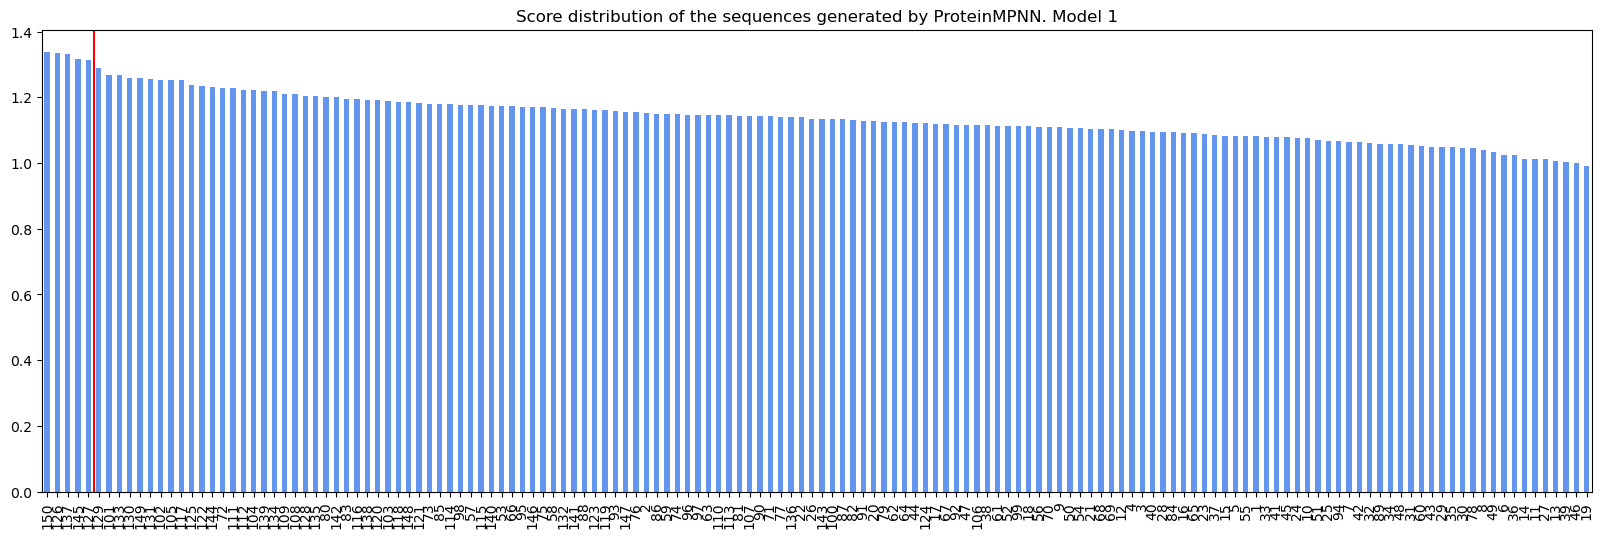

In [9]:
import matplotlib.pyplot as plt
df_binder_1['Score'].plot(kind='bar', color='cornflowerblue', figsize=(20, 6))
plt.axvline(4.5, color = 'r')
plt.title('Score distribution of the sequences generated by ProteinMPNN. Model 1')
#plt.savefig('score_distribution_model_1.png', dpi=600, bbox_inches='tight')

In [5]:
top_sequences = {}
score_ranges = []  # List to store score range data

for key in df_dict.keys():
    # Sort the dataframe by the 'Score' column in descending order
    df_sorted = df_dict[key].sort_values(by=["Score"], ascending=False)
    
    # Remove the first row
    df_sorted = df_sorted.iloc[1:]
    
    # Get the top 5 sequences
    top_sequences[key] = df_sorted.iloc[:5][["Sequence", "Score"]]
    
    # Print the results
    print(f"Top 5 sequences for {key}:")
    print(top_sequences[key])
    print("-" * 50)
    
    # Store score range data
    min_score = df_sorted["Score"].min()
    max_score = df_sorted["Score"].max()
    score_ranges.append([key, min_score, max_score])

# Create a DataFrame for score ranges
score_range_df = pd.DataFrame(score_ranges, columns=["Binder", "Min_Score", "Max_Score"]).sort_values(by=["Max_Score"], ascending=False)
print("Score Ranges Table:")
display(score_range_df)

Top 5 sequences for df_binder_1:
                                              Sequence   Score
150  ASIRAAMEAERLETVTRICDMTNPLVREAFEEASEEERKAQRKATA...  1.3387
126  SSIAASFRLSQLLSVLRICDFSLPEVREAFRAATPEQRRAHIIGTA...  1.3350
137  EELSTSFSSDQAESVLNLCDVSDPEVRAALAEASPAEAAAHRTATA...  1.3305
145  SEISQQMRKQNTEQVLAVCDFSDPEVLEAYRAASPAERRALDIGTA...  1.3151
127  SAIASAFRQENLQQVIAICDFSNPAVAEAFRKASPAERAALTIAAA...  1.3141
--------------------------------------------------
Top 5 sequences for df_binder_11:
                                              Sequence   Score
114  MEEALKQMQESAEKWSKEIEETLRTKGREAALEKIDQMISYLSQQE...  1.6454
112  SEATLAEIQKMADEAREQIQRLLATDGESLAAQARSEMISAINNAV...  1.6075
148  MEETLKKIQEESRKYQKKIEEIRATEGEEAASQLENEMNSKINDAV...  1.5791
109  VEATLEEIQKLSREDEAAIKEALATEGEEAAEALVNESISRINSLV...  1.5538
143  VEAALSAMQDLYDKKKKEIEEAKATLGDEAAAELESQMIKELTDMV...  1.5511
--------------------------------------------------
Top 5 sequences for df_binder_13:
                                         

,Binder,Min_Score,Max_Score
1,df_binder_11,1.2107,1.6454
4,df_binder_15,1.2060,1.5120
5,df_binder_17,1.0480,1.4805
2,df_binder_13,1.0591,1.4417
6,df_binder_19,1.0029,1.3997
9,df_binder_9,1.0201,1.3893
8,df_binder_8,0.9004,1.3571
0,df_binder_1,0.9915,1.3387
7,df_binder_3,0.8549,1.2454
3,df_binder_14,0.8913,1.1911
